In [2]:
import csv
import bq
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

In [4]:
client = bq.Client.Get()

def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [5]:
startdate = '2015-01-01'
enddate = '2015-12-31'

q = '''
select integer(positions/50)*50 positions, count(*) num_vessels 
FROM
(
  SELECT
    mmsi, count(*) as positions
  FROM (TABLE_DATE_RANGE([pipeline_normalize.], TIMESTAMP('{0}'), TIMESTAMP('{1}')))
  WHERE
    lat IS NOT NULL AND lon IS NOT NULL
  GROUP BY
    mmsi
) group by positions order by positions asc
'''.format(startdate, enddate)

pos = Query(q)

Waiting on bqjob_r1e83543e407a8d8d_000001592874af2b_1 ... (109s) Current status: DONE   
Query time: 113.970089197 seconds.


In [7]:
v = np.array([int(p[0]) for p in pos])
p = np.array([int(p[1]) for p in pos])

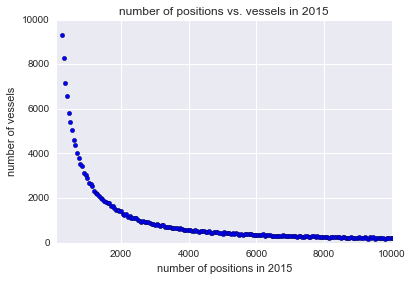

In [8]:
# plt.plot(np.log10(v),np.log10(p))
plt.scatter(v,p)
plt.xlim(100,10000)
plt.ylim(0,10000)
plt.ylabel("number of vessels")
plt.xlabel("number of positions in 2015")
plt.title("number of positions vs. vessels in 2015")
plt.show()

# Let's look at the distribution of number of vessels active per day

In [ ]:
q='''SELECT
  integer(days/10)*10 AS active_days,
  COUNT(*) number_mmsi
FROM (
  SELECT
    mmsi,
    COUNT(*) days
  FROM (
    SELECT
      mmsi,
      DATE(timestamp) date
    FROM
      [world-fishing-827:scratch_global_fishing_raster.2015_with_score_and_hours_fishing]
    WHERE
      speed > 2
      and mmsi in (select mmsi from [world-fishing-827:scratch_david_mmsi_lists.2015_all_fishing_v2]
      where average_length>24)
    GROUP BY
      mmsi,
      date)
  GROUP BY
    mmsi)
GROUP BY
  active_days
ORDER BY
  active_days ASC'''
days_activeBIG = Query(q)


q='''SELECT
  integer(days/10)*10+3.3 AS active_days,
  COUNT(*) number_mmsi
FROM (
  SELECT
    mmsi,
    COUNT(*) days
  FROM (
    SELECT
      mmsi,
      DATE(timestamp) date
    FROM
      [world-fishing-827:scratch_global_fishing_raster.2015_with_score_and_hours_fishing]
    WHERE
      speed > 2
      and mmsi in (select mmsi from [world-fishing-827:scratch_david_mmsi_lists.2015_all_fishing_v2] 
      where average_length>12
      and average_length<=24)
    GROUP BY
      mmsi,
      date)
  GROUP BY
    mmsi)
GROUP BY
  active_days
ORDER BY
  active_days ASC'''
days_activeMedium = Query(q)


q='''SELECT
  integer(days/10)*10+6.6 AS active_days,
  COUNT(*) number_mmsi
FROM (
  SELECT
    mmsi,
    COUNT(*) days
  FROM (
    SELECT
      mmsi,
      DATE(timestamp) date
    FROM
      [world-fishing-827:scratch_global_fishing_raster.2015_with_score_and_hours_fishing]
    WHERE
      speed > 2
      and mmsi in (select mmsi from [world-fishing-827:scratch_david_mmsi_lists.2015_all_fishing_v2]
      where average_length<12)
    GROUP BY
      mmsi,
      date)
  GROUP BY
    mmsi)
GROUP BY
  active_days
ORDER BY
  active_days ASC'''
days_activeSMALL = Query(q)



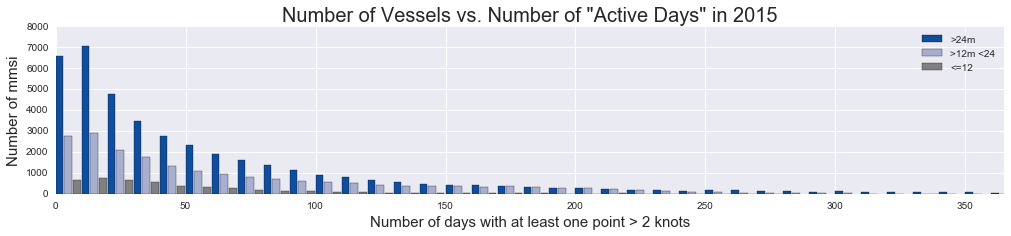

In [18]:
active_daysBIG = np.array([int(p[0]) for p in days_activeBIG])
number_mmsiBIG = np.array([int(p[1]) for p in days_activeBIG])

active_daysMedium = np.array([float(p[0]) for p in days_activeMedium])
number_mmsiMedium = np.array([int(p[1]) for p in days_activeMedium])

active_daysSMALL = np.array([float(p[0]) for p in days_activeSMALL])
number_mmsiSMALL = np.array([int(p[1]) for p in days_activeSMALL])

plt.rcParams["figure.figsize"] = [17,3]
nd = np.arange(370/10)
plt.xlim(0,365)

plt.bar(active_daysBIG,number_mmsiBIG,3, color="#104D9D", label='>24m')#, color=sb.color_palette("Blues",3))
plt.bar(active_daysMedium,number_mmsiMedium,3, color="#A8AECE", label='>12m <24')#, color=sb.color_palette("Blues",3))
plt.bar(active_daysSMALL,number_mmsiSMALL,3,color="#808080",label="<=12")#, color=sb.color_palette("Blues",3))


plt.title('Number of Vessels vs. Number of "Active Days" in 2015', fontsize=20)
plt.legend()
plt.xlabel("Number of days with at least one point > 2 knots",fontsize="15")
plt.ylabel("Number of mmsi",fontsize="15") 
plt.show()

# Now plot semilog

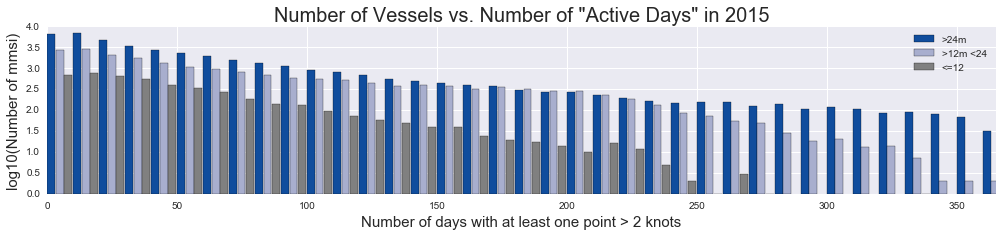

In [19]:
plt.xlim(0,365)
plt.bar(active_daysBIG,np.log10(number_mmsiBIG),3, color="#104D9D", label='>24m')#, color=sb.color_palette("Blues",3))
plt.bar(active_daysMedium,np.log10(number_mmsiMedium),3, color="#A8AECE", label='>12m <24')#, color=sb.color_palette("Blues",3))
plt.bar(active_daysSMALL,np.log10(number_mmsiSMALL),3,color="#808080",label="<=12")#, color=sb.color_palette("Blues",3))

plt.title('Number of Vessels vs. Number of "Active Days" in 2015', fontsize=20)
plt.legend()
plt.xlabel("Number of days with at least one point > 2 knots",fontsize="15")
plt.ylabel("log10(Number of mmsi)",fontsize="15") 
plt.show()